# Libraries

In [31]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import numpy as np
import copy
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from utils import plot_time_series_class, convert2tensor, predict, plot_prediction
import warnings

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Parameters

In [32]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
COLORS = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(COLORS))

# Neural network
beta = 1e-2
embedding_dim = 128

# Training 
options = 1         # If options = 1 we start a new training
num_epochs = 250
batch_size = 16
learning_rate = 1e-5

# Others
data_proportional = 1
SEED = 99

np.random.seed(SEED)
torch.manual_seed(SEED)

# Data

### Data load

In [33]:
test = pd.read_csv('./Data/ECG5000_TEST.txt').to_numpy()
train = pd.read_csv('./Data/ECG5000_TRAIN.txt').to_numpy()

In [34]:
test = np.array([row[0].split() for row in test])
test = test.astype(np.float32)
train = np.array([row[0].split() for row in train])
train = train.astype(np.float32)

### Classes

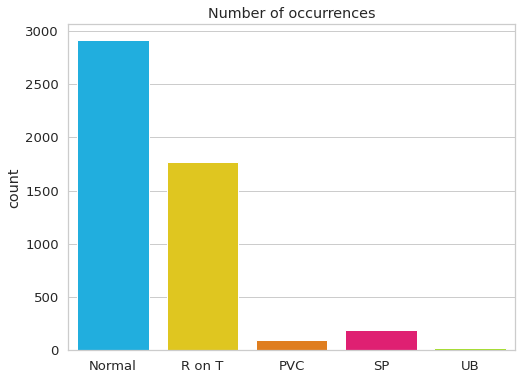

In [35]:
class_names = ['Normal','R on T','PVC','SP','UB']
data = np.concatenate((test, train))
np.random.shuffle(data)
data = data[:int(data_proportional*data.shape[0])]

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(data[:,0])   
ax.set_xticklabels(class_names)
ax.set_title("Number of occurrences")
fig.savefig("./Images/occurrences.png")

### Mean and variance of each class

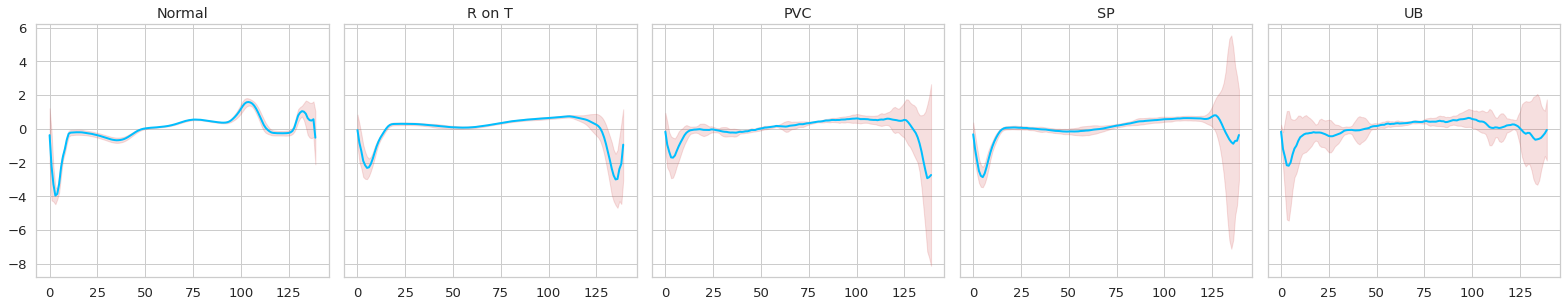

In [36]:
classes = np.unique(data[:,0]).astype(np.int32)

fig, axs = plt.subplots(nrows=1, ncols=5, sharey = True, figsize=(22, 4.5))
for k in range(0,len(classes)):
  ax = axs.flat[k]
  data_plot = data[data[:,0] == k+1][:,1:]    # k+1 for ecg5000
  plot_time_series_class(data_plot, class_names[k], ax)
fig.tight_layout()
fig.savefig("./Images/mean_variance_data.png")


# Data preprocessing

### Scaling

In [37]:
sc_X = StandardScaler()
data[:,1:] = sc_X.fit_transform(data[:,1:])

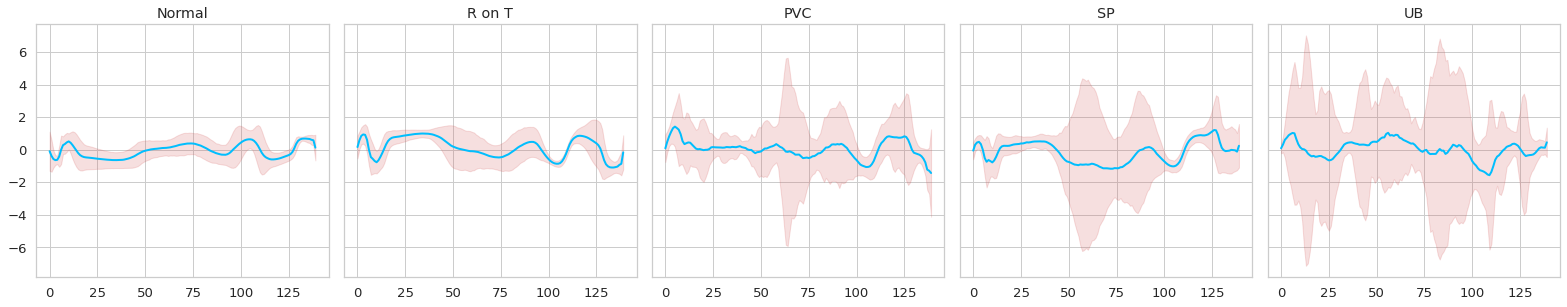

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=5, sharey = True, figsize=(22, 4.5))
for k in range(0,len(classes)):
  ax = axs.flat[k]
  data_plot = data[data[:,0] == k+1][:,1:]    # k+1 for ecg5000
  plot_time_series_class(data_plot, class_names[k], ax)
fig.tight_layout()
fig.savefig("./Images/mean_variance_preprocessed_data.png")

### Anomalies and normal occurrences

In [39]:
normal_ecg= data[data[:,0] == 1][:,1:]
anomaly_set = data[data[:,0] != 1][:,1:]
print(f"Number of normal occurrences: {normal_ecg.shape[0]}")
print(f"Number of anomalies: {anomaly_set.shape[0]}")

Number of normal occurrences: 2917
Number of anomalies: 2081


### Data split

In [40]:
training_set, validation_set = train_test_split(normal_ecg, test_size=0.2, random_state=SEED)
validation_set, test_normal_set = train_test_split(validation_set, test_size=0.5,  random_state=SEED)

In [41]:
training_set, seq_len, n_features = convert2tensor(training_set)
validation_set, _, _ = convert2tensor(validation_set)
test_normal_set, _, _ = convert2tensor(test_normal_set)
test_anomaly_set, _, _ = convert2tensor(anomaly_set)

# LSTM_VAE

In [42]:
class LSTM_VAE(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim):
        super(LSTM_VAE, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 4 * embedding_dim

        self.encoder_rnn1 = nn.LSTM(input_size=self.n_features, hidden_size=self.hidden_dim, num_layers=1, batch_first=True)
        self.encoder_rnn2 = nn.LSTM(input_size=self.hidden_dim, hidden_size=self.hidden_dim//2, num_layers=1, batch_first=True)
        self.encoder_output_mean = nn.Linear(self.hidden_dim//2, self.embedding_dim)
        self.encoder_output_log_var = nn.Linear(self.hidden_dim//2, self.embedding_dim)

        self.decoder_rnn1 = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_dim//2, num_layers=1, batch_first=True)
        self.decoder_rnn2 = nn.LSTM(input_size=self.hidden_dim//2, hidden_size=self.hidden_dim, num_layers=1, batch_first=True)
        self.decoder_output_mean = nn.Linear(self.hidden_dim, self.n_features)


    def encode(self, x):
        x = x.reshape((x.shape[0], self.seq_len, self.n_features))
        x, (_, _) = self.encoder_rnn1(x)
        x, (hidden_n, _) = self.encoder_rnn2(x)
        hiddens = hidden_n.reshape((x.shape[0], self.n_features, x.shape[2]))
        output_mean, output_log_var = self.encoder_output_mean(hiddens), self.encoder_output_log_var(hiddens)

        return output_mean, output_log_var


    def decode(self, z):
        z = z.repeat(1, self.seq_len, self.n_features)
        z = z.reshape((z.shape[0], self.seq_len, self.embedding_dim))
        z, (hidden_n, cell_n) = self.decoder_rnn1(z)
        z, (hidden_n, cell_n) = self.decoder_rnn2(z)
        z = z.reshape((z.shape[0], self.seq_len, self.hidden_dim))
        output_mean = self.decoder_output_mean(z)

        return output_mean
    

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)

        return mu + eps * std


    def loss_function(self, x, x_hat, mu, log_var):
        batch_size = x.shape[0]
        reconst_loss = 0.5 * torch.sum( (x_hat - x)**2 ) / batch_size
        regu_loss = - 0.5 * torch.sum( log_var - mu**2 - torch.exp(log_var) ) / batch_size

        return reconst_loss + regu_loss*beta
        
        
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        
        return x_hat, mu, log_var

# Model initialization

In [43]:
model = LSTM_VAE(seq_len, n_features, embedding_dim=embedding_dim)
model = model.to(device)
training_generator = DataLoader(training_set, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True, drop_last=True)
validation_generator = DataLoader(validation_set, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True, drop_last=True)
print(model)

LSTM_VAE(
  (encoder_rnn1): LSTM(1, 512, batch_first=True)
  (encoder_rnn2): LSTM(512, 256, batch_first=True)
  (encoder_output_mean): Linear(in_features=256, out_features=128, bias=True)
  (encoder_output_log_var): Linear(in_features=256, out_features=128, bias=True)
  (decoder_rnn1): LSTM(128, 256, batch_first=True)
  (decoder_rnn2): LSTM(256, 512, batch_first=True)
  (decoder_output_mean): Linear(in_features=512, out_features=1, bias=True)
)


# Training

### Over one epoch

In [44]:
def train_model_one_epoch(model, training_set, iepoch, optimizer):
    model = model.train()
    train_losses = []

    with tqdm(training_set, unit="batch") as tepoch:
      for mini_batch in tepoch:
        tepoch.set_description(f"Epoch {iepoch}: Training")

        optimizer.zero_grad()
        mini_batch = mini_batch.to(device)
        mini_batch_pred, mu, log_var = model(mini_batch)

        loss = model.loss_function(mini_batch, mini_batch_pred,  mu, log_var)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        tepoch.set_postfix(loss=np.mean(train_losses))

    return model, optimizer, train_losses

def eval_model_one_epoch(model, validation_set, iepoch, optimizer):
    model = model.eval()
    val_losses = []
    
    with torch.no_grad():
      with tqdm(validation_set, unit="batch") as tepoch:
          for mini_batch in tepoch:
            tepoch.set_description(f"Epoch {iepoch}: Validation")
            
            optimizer.zero_grad()
            mini_batch = mini_batch.to(device)
            mini_batch_pred, mu, log_var = model(mini_batch)

            loss = model.loss_function(mini_batch, mini_batch_pred,  mu, log_var)

            val_losses.append(loss.item())
            tepoch.set_postfix(validation=np.mean(val_losses))

    return model, optimizer, val_losses

### Over n epochs

In [45]:
def train_model(model, train_dataset, val_dataset, n_epochs, learning_rate):
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  history = dict(train=[], val=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = np.inf

  for epoch in range(1, n_epochs + 1):
    model, optimizer, train_losses = train_model_one_epoch(model, train_dataset, epoch, optimizer)
    model, optimizer, val_losses = eval_model_one_epoch(model, val_dataset, epoch, optimizer)

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

  model.load_state_dict(best_model_wts)
  torch.save(model, './Checkpoints/best_model.zip')
  torch.save(history, './Checkpoints/history.zip')

  return model.eval(), history

### Training model

In [46]:
if options==1:
    model, history = train_model(model, training_generator, validation_generator, num_epochs, learning_rate)
else:
    model = torch.load('./Checkpoints/best_model.zip')
    history = torch.load('./Checkpoints/history.zip')
    model = model.to(device)

Epoch 250: Validation: 100%|██████████| 18/18 [00:00<00:00, 32.86batch/s, validation=10.5]


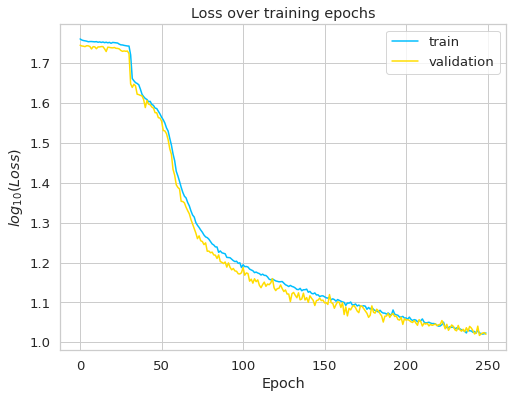

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(np.log10(history['train']))
ax.plot(np.log10(history['val']))
plt.ylabel('$log_{10}(Loss)$')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.title('Loss over training epochs')
fig.savefig("./Images/loss.png")
plt.show()

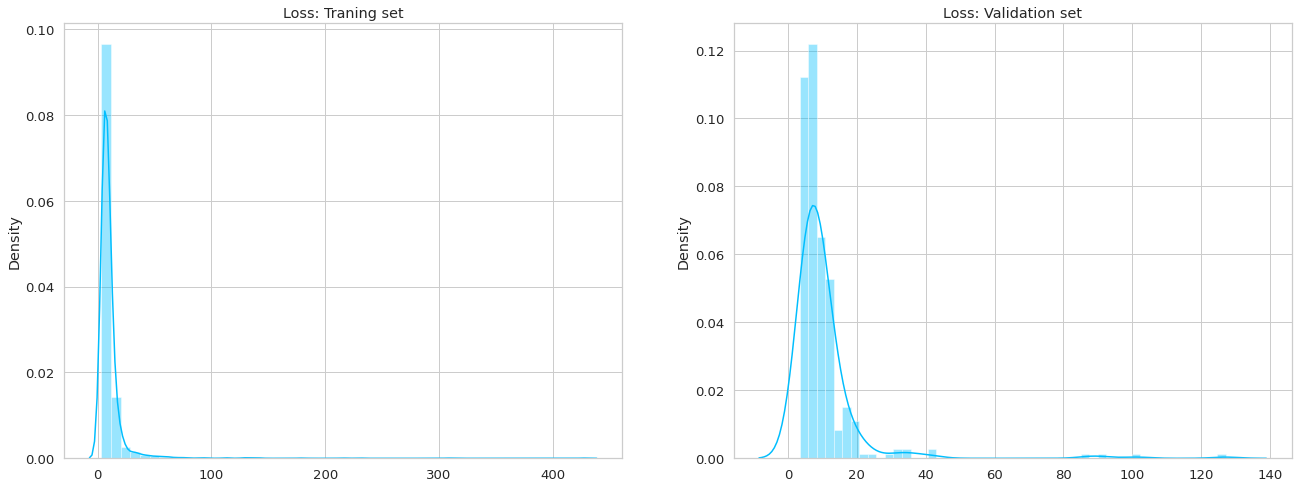

In [50]:
_, training_losses = predict(model, training_set)
_, validation_losses = predict(model, validation_set)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))
sns.distplot(training_losses, ax=ax[0])
sns.distplot(validation_losses, ax=ax[1])
ax[0].set_title("Loss: Traning set")
ax[1].set_title("Loss: Validation set")
fig.savefig("./Images/results_training_set.png")

# Test

In [51]:
_, test_normal_losses = predict(model, test_normal_set)
_, anomaly_losses = predict(model, test_anomaly_set)

In [52]:
th =np.quantile(validation_losses, 0.95)
print(f"Threshold: {th}")

Threshold: 20.52259588241577


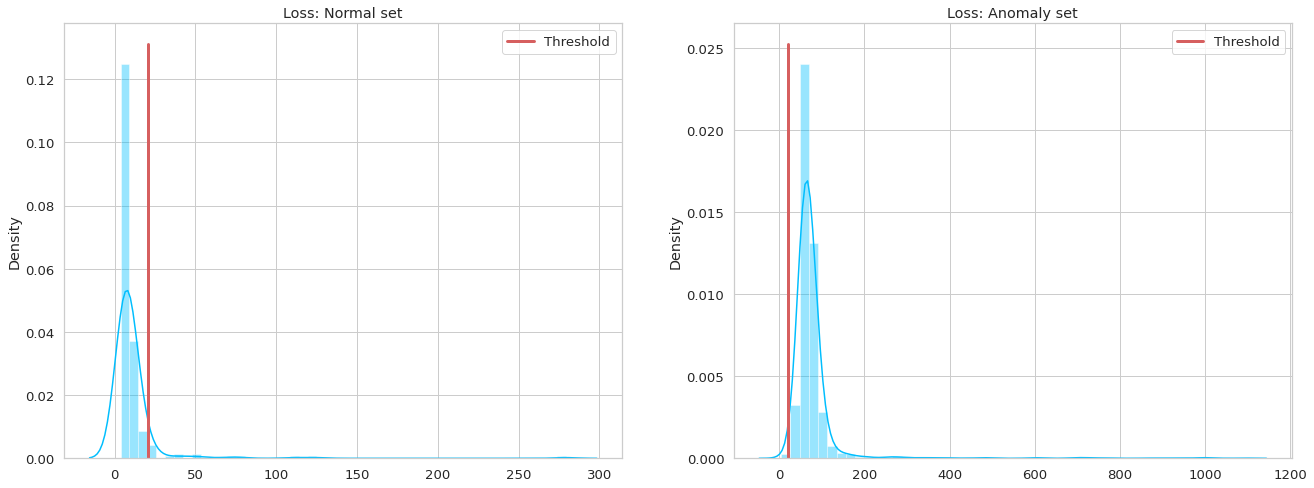

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))
sns.distplot(test_normal_losses, ax=ax[0])
sns.distplot(anomaly_losses, ax=ax[1])
ax[0].set_title("Loss: Normal set")
ax[0].plot(np.array([1, 1])*th, np.array([0, fig.axes[0].get_ylim()[1]]), color='r', lw=3, label="Threshold")
ax[0].legend()
ax[1].set_title("Loss: Anomaly set")
ax[1].plot(np.array([1, 1])*th, np.array([0, fig.axes[1].get_ylim()[1]]),  color='r', lw=3, label="Threshold")
ax[1].legend()
fig.savefig("./Images/results_test_set.png")

# Analysis

In [54]:
print(f'True positive: {test_normal_losses.shape[0]-test_normal_losses[test_normal_losses>th].shape[0]}/{test_normal_losses.shape[0]}')
TP = test_normal_losses.shape[0]-test_normal_losses[test_normal_losses>th].shape[0]

print(f'False positive: {test_normal_losses[test_normal_losses>th].shape[0]}/{test_normal_losses.shape[0]}')
FP = test_normal_losses[test_normal_losses>th].shape[0]

print(f'True negative: {anomaly_losses.shape[0]-anomaly_losses[anomaly_losses<th].shape[0]}/{anomaly_losses.shape[0]}')
TN = anomaly_losses.shape[0]-anomaly_losses[anomaly_losses<th].shape[0]

print(f'False negative: {anomaly_losses[anomaly_losses<th].shape[0]}/{anomaly_losses.shape[0]}')
FN = anomaly_losses[anomaly_losses<th].shape[0]

True positive: 275/292
False positive: 17/292
True negative: 2073/2081
False negative: 8/2081


### Metrics

In [55]:
accuracy = (TP + TN)/(TP + TN + FP + FN)
precision = TP/(TP + FP)
recall = TP/(TP + FN)
F1_score = 2*(precision*recall)/(precision + recall)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {F1_score}')

Accuracy: 0.989464812473662
Precision: 0.9417808219178082
Recall: 0.9717314487632509
F1 Score: 0.9565217391304347


### Reconstruction

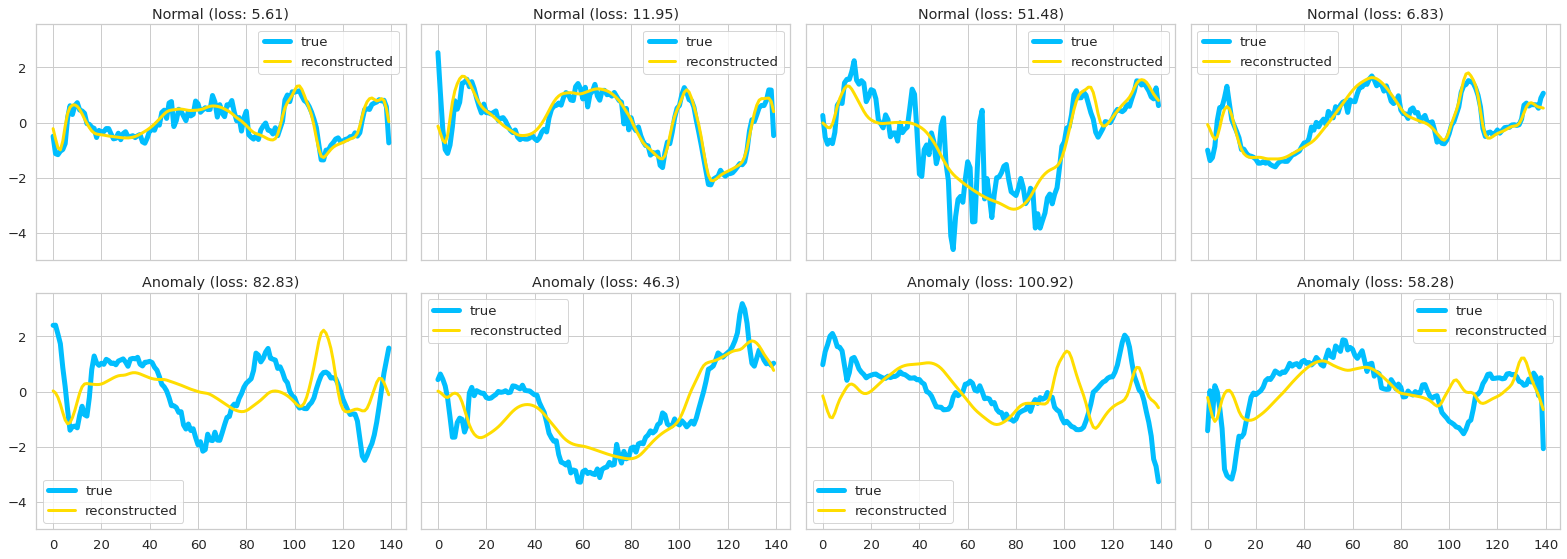

In [56]:
fig, axs = plt.subplots(nrows=2, ncols=4, sharey=True, sharex=True, figsize=(22, 8))

for i, datax in enumerate(test_normal_set[:4]):
  plot_prediction(datax, model, title='Normal', ax=axs[0, i])
  
for i, datax in enumerate(test_anomaly_set[:4]):
  plot_prediction(datax, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout()
fig.savefig("./Images/reconstruction.png")